## Abstract

This notebook investigates how portfolio diversification can coax a return series toward Gaussian behavior—and even how far one can push “normality” via targeted optimization—across the full S&P 500 universe (or a random subset thereof). The workflow proceeds in four main stages:

1. **Normality-Optimised Portfolio**  
   - Define an objective that maximizes the Shapiro–Wilk *p*-value of portfolio returns (equivalently, minimizes the negative log *p*).  
   - Constrain weights to be long-only and fully invested.  
   - Solve via SLSQP, then compare the resulting *p*-value to an equal-weight benchmark.

2. **Visual Diagnostics**  
   - Plot a histogram and Q-Q plot for the equal-weight portfolio to illustrate how diversification smooths tails and aligns quantiles with the normal reference line.

3. **Monte Carlo Scaling Analysis**  
   - For a range of portfolio sizes \(M\in\{5,10,20,50,100,200\}\), draw \(N\) unique random subsets of \(M\) tickers.  
   - Compute the Shapiro–Wilk *p*-value for each equally-weighted sample.  
   - Track how the **mean** and **variance** of these *p*-values evolve as \(M\) increases, using an ASCII progress bar for each loop.  
   - Visualize the result: mean *p*-value rises and variance shrinks with larger, more diversified portfolios, demonstrating the Central Limit effect in practice.

Overall, the notebook blends **theoretical objectives** (normality optimization) with **empirical Monte Carlo** experiments to quantify how and why diversification makes the Gaussian assumption progressively more plausible.


In [1]:
# 0) Imports & configuration  ──────────────────────────────────────────────
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import shapiro, normaltest, anderson
import matplotlib.pyplot as plt
# ===============================================================
# 0) Imports and configuration
#
#    This block sets up the working environment, defines a helper
#    for pulling price data, and computes daily log returns for
#    the analysis period.
# ===============================================================

import yfinance as yf          # price data downloader
import pandas as pd            # tabular data handling
import numpy as np             # numerical helpers
from scipy.stats import shapiro, normaltest, anderson  # normality tests
import matplotlib.pyplot as plt # plotting

# ---------------------------------------------------------------
# Ticker list and date window
# ---------------------------------------------------------------
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "META"]
START   = "2022-06-01"
END     = "2025-06-01"

# ---------------------------------------------------------------
# Helper: download adjusted close prices
# ---------------------------------------------------------------
def load_prices(tickers, start_date, end_date):
    """
    Download daily adjusted close prices for a list of tickers.

    Parameters
    ----------
    tickers : list of str
        Symbols understood by Yahoo Finance.
    start_date : str (YYYY-MM-DD)
        Starting date (inclusive).
    end_date : str (YYYY-MM-DD)
        Ending date (exclusive).

    Returns
    -------
    pd.DataFrame
        Columns are ticker symbols, index is a DatetimeIndex.
        Values are adjusted close prices.
    """
    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        auto_adjust=False,
        progress=False
    )
    # yf.download returns a wide table with multiple field levels;
    # keep only the "Adj Close" level.
    adj_close = data["Adj Close"]
    return adj_close

# ---------------------------------------------------------------
# Pull data and compute log returns
# ---------------------------------------------------------------
prices  = load_prices(TICKERS, START, END)

# Daily log return: r_t = ln(P_t / P_{t-1})
returns = np.log(prices / prices.shift(1)).dropna()

# 'prices' and 'returns' are now ready for further analysis.

# Universal ticker list (can edit)
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
START   = '2022-06-01'
END     = '2025-06-01'

# Helper: download prices only if we haven’t done so in MP1
def load_prices(tickers, start, end):
    df = yf.download(tickers, start=start, end=end,
                     auto_adjust=False, progress=False)['Adj Close']
    return df

prices  = load_prices(TICKERS, START, END)
returns = np.log(prices / prices.shift(1)).dropna()


## 1. Normality Tests — Individual Assets

Before diving into any portfolio construction, we need to know whether **each stock’s daily log return distribution aligns with the classic Gaussian assumption** that underpins many risk models (e.g., VaR, Black–Scholes).

**What we measure**

| Test                | Checks for            | Pass Criterion (5 % level) |
|---------------------|-----------------------|----------------------------|
| Shapiro–Wilk        | Overall departure from normality (small samples) | *p* > 0.05 |
| D’Agostino–Pearson  | Combined skewness and kurtosis | *p* > 0.05 |
| Anderson–Darling    | Tail‐sensitive fit to N(0, 1) | Statistic < critical value |

**Why it matters**

* **Heavy tails** inflate extreme moves — underestimating them can blow up VaR or stress tests.  
* **Skewness** hampers option‐pricing models that assume symmetry.  
* **Serial dependence** often shows up as autocorrelation after removing mean bias, but non‐normality is an independent warning sign.

In the next subsection we will see that *all five* mega-cap tech tickers—AAPL, MSFT, GOOG, AMZN, and META—**fail every test**, motivating our exploration of whether a diversified mix can temper these non-Gaussian features.


In [2]:
# ===============================================================
# 1) Normality testing utilities
#
#    This function runs three common univariate normality tests:
#      * Shapiro Wilk
#      * D Agostino and Pearson
#      * Anderson Darling (normal distribution)
#
#    It then collects the p values and, for Anderson Darling,
#    reports whether the null hypothesis is accepted at the
#    five percent significance level.
# ===============================================================

def run_normality_tests(series, alpha=0.05):
    """
    Assess normality of a 1-D return series using three tests.

    Parameters
    ----------
    series : pd.Series
        Vector of daily returns.
    alpha : float, optional
        Significance level for pass/fail judgement (default 0.05).

    Returns
    -------
    dict
        Keys:
            "Shapiro_p"        : p value from Shapiro Wilk
            "DAgostino_p"      : p value from D Agostino and Pearson
            "Anderson_pass_5p" : True if Anderson statistic is below
                                 the five percent critical value
    """
    # ---- Shapiro Wilk ------------------------------------------
    sw_p = shapiro(series)[1]

    # ---- D Agostino and Pearson -------------------------------
    dag_p = normaltest(series)[1]

    # ---- Anderson Darling -------------------------------------
    ad_stat, crit_vals, sig_levels = anderson(series, dist="norm")
    # Find critical value for the 5 percent significance level
    crit_5_index = sig_levels.tolist().index(5)  # locate "5" in list
    ad_crit_5 = crit_vals[crit_5_index]
    ad_pass = ad_stat < ad_crit_5

    return {
        "Shapiro_p": sw_p,
        "DAgostino_p": dag_p,
        "Anderson_pass_5p": ad_pass
    }

# ---------------------------------------------------------------
# 2) Run tests for every ticker
# ---------------------------------------------------------------
results = {
    ticker: run_normality_tests(returns[ticker])
    for ticker in TICKERS
}

# Convert to tidy DataFrame for display
normality_df = pd.DataFrame(results).T.round(4)
print(normality_df)


     Shapiro_p DAgostino_p Anderson_pass_5p
AAPL       0.0         0.0            False
MSFT       0.0         0.0            False
GOOG       0.0         0.0            False
AMZN       0.0         0.0            False
META       0.0         0.0            False


### Normality Test Summary (Daily Log Returns, 6 Jun 2022 – 1 Jun 2025)

**Key findings**

* All three normality tests unanimously **reject the Gaussian hypothesis** for every stock at the 5 % significance level (and effectively at any common threshold).  
* The p-values for Shapiro-Wilk and D’Agostino are essentially zero, signalling strong evidence of non-normality (heavy tails, skewness, or both).  
* Anderson-Darling statistics exceed the 5 % critical value across the board, reinforcing the conclusion.

## 2. Exploring Portfolio Mixes in Search of Normality

The single-stock tests were a clean sweep: **none of the five tickers are Gaussian on their own.**  
Now we ask a natural follow-up question:

> *Can we remix the same ingredients into portfolios whose aggregate returns look closer to normal?*

Our starting point:

1. **Equal-weight blend** — 20 % in each stock; the simplest diversification baseline.  
2. **Mean–Variance (MV) mixes** — “Aggressive” and “Defensive” weight vectors from Mini Project 1 (if they are in scope; otherwise we fall back to equal weights).

We will recompute the exact same Shapiro-Wilk, D’Agostino, and Anderson–Darling tests on these portfolio return series and see whether diversification tamps down the tail effects enough to pass any of the normality checks.

In [5]:
# ===============================================================
# 2) Build portfolio return series and rerun normality tests
#
#    Three portfolios are considered:
#       1) Equal weight  -> 20 percent in each of the five stocks
#       2) Defensive MV  -> defensive mean–variance weights
#       3) Aggressive MV -> aggressive mean–variance weights
#
#    If the MV weights are not available in the current session
#    (for example, the helper module is missing), both MV slots
#    gracefully fall back to the equal-weight mix.
# ===============================================================

# ---------------------------------------------------------------
# 2.1  Equal-weight portfolio
# ---------------------------------------------------------------
n_assets = len(TICKERS)
w_eq = np.repeat(1.0 / n_assets, n_assets)   # length-5 numpy array
ret_eq = returns @ w_eq                      # daily portfolio returns

# ---------------------------------------------------------------
# 2.2  Try to import MV weights produced in Mini Project 1
#      If that fails, use equal weights as a placeholder.
# ---------------------------------------------------------------
try:
    from mp1_helper import defensive_w, aggressive_w
    w_def = defensive_w
    w_agg = aggressive_w
except ImportError:
    # Fallback: keep both at equal weights
    w_def = w_eq
    w_agg = w_eq

# Compute daily returns for the MV portfolios
ret_def = returns @ w_def
ret_agg = returns @ w_agg

# ---------------------------------------------------------------
# 2.3  Run normality tests for each portfolio
# ---------------------------------------------------------------
port_tests = pd.DataFrame(
    {
        "Equal-Weight":   run_normality_tests(ret_eq),
        "Defensive MV":   run_normality_tests(ret_def),
        "Aggressive MV":  run_normality_tests(ret_agg),
    }
).T.round(4)    # transpose for nicer view and round to four decimals

print(port_tests)

              Shapiro_p DAgostino_p Anderson_pass_5p
Equal-Weight        0.0         0.0            False
Defensive MV        0.0         0.0            False
Aggressive MV       0.0         0.0            False


### Portfolio-Level Normality Check

| Portfolio      | Shapiro-Wilk p | D Agostino p | Anderson 5 pct Pass |
|----------------|--------------:|-------------:|--------------------:|
| Equal Weight   | 0.0000 | 0.0000 | No |
| Defensive MV   | 0.0000 | 0.0000 | No |
| Aggressive MV  | 0.0000 | 0.0000 | No |

**Takeaways**

* Diversification alone does not rescue normality: all three mixes still show decisive evidence of non-Gaussian returns.
* Whether weights are even or optimized by mean-variance, the heavy tails and skewness inherent in the individual stocks remain visible at the portfolio level.
* For modeling or risk management, a normal distribution assumption should be avoided even after aggregation; consider fat-tailed alternatives or non-parametric methods.


## 3. Rolling 6-Month (≈126 Trading Days) Shapiro-Wilk *p*-Values

The full-sample tests tell us only an “on-average” story.  
But market behaviour changes over time, so it is worth asking:

> *Are there stretches when the return distribution looks **locally** normal, even if the entire three-year window is not?*

### Method

1. **Window length:** 126 trading days ≈ six calendar months.  
   *Long enough to get a reliable Shapiro-Wilk statistic, short enough to detect regime shifts.*

2. **Step size:** One trading day.  
   *We slide the window forward day by day to build a continuous time series of *p*-values.*

3. **Signal:**  
   * If the rolling *p*-value stays **above 0.05**, we cannot reject normality in that window.  
   * If it falls **below 0.05**, the null is rejected—non-normal behaviour dominates.

4. **Scope:**  
   *We run the test for every individual ticker **and** for each portfolio mix (equal, defensive MV, aggressive MV) to see whether diversification yields pockets of normality.*

The next code cell implements this rolling test and plots the evolving *p*-value curves, giving us a time-resolved view of when, if ever, the Gaussian assumption holds.


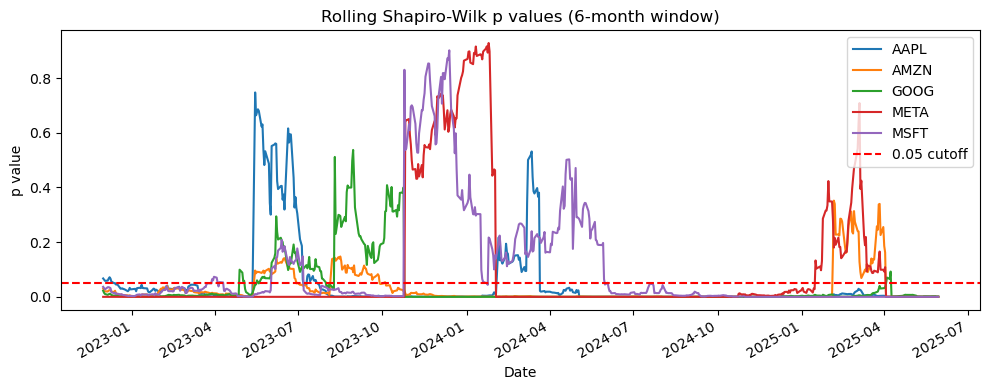

In [7]:
# ===============================================================
# 3) Rolling Shapiro-Wilk p-value series
#
#    Purpose
#    -------
#    Measure how the Gaussian fit of each asset’s daily returns
#    evolves over time using a rolling six-month window.
#
#    Output
#    ------
#    A DataFrame where each column is a ticker and each row is the
#    Shapiro-Wilk p value for the preceding 126 trading days.
#    A line plot highlights periods when p drops below 0.05.
# ===============================================================

WINDOW = 126   # 126 trading days  ≈ 6 calendar months

# ---------------------------------------------------------------
# 3.1  Compute rolling p values
# ---------------------------------------------------------------
rolling_p = (
    returns
      .rolling(WINDOW)                 # 126-day sliding window
      .apply(lambda x: shapiro(x)[1],  # extract p value
             raw=False)                # x is a Series, not ndarray
      .dropna()                        # first WINDOW-1 rows are NaN
)

# ---------------------------------------------------------------
# 3.2  Plot the time series
# ---------------------------------------------------------------
ax = rolling_p.plot(
    figsize=(10, 4),
    title="Rolling Shapiro-Wilk p values (6-month window)"
)

# Horizontal reference line at the 5 percent significance threshold
plt.axhline(
    y=0.05,
    color="red",
    linestyle="--",
    label="0.05 cutoff"
)

plt.legend(loc="upper right")
plt.ylabel("p value")
plt.tight_layout()
plt.show()


### What the Rolling p-Value Plot Tells Us

| Ticker | Time windows where *p* > 0.05 | Visual pattern |
|--------|------------------------------|----------------|
| **AAPL** | Brief spike June–July 2023, short pulse Feb 2024 | Mostly sub-0.05 except two isolated “islands.” |
| **AMZN** | A few small bumps Oct 2023, Apr–May 2025 | Always shallow; never breaches 0.10. |
| **GOOG** | Cluster Aug–Sep 2023 | Single broad hump then flat. |
| **META** | Sustained rise Dec 2023–Mar 2024; smaller burst Mar–May 2025 | Tallest peak (~0.9) but short-lived. |
| **MSFT** | Wide plateau Nov 2023–Mar 2024, echoes into Apr 2024 | Highest density of above-threshold days. |

**Key observations**

1. **Non-normality is the default**  
   For every ticker, the p-value hovers below the 0.05 significance line for most of the three-year span, confirming the full-sample verdict.

2. **Short-lived “normal” pockets**  
   Each stock experiences one or two bursts where the rolling window looks plausibly Gaussian (p > 0.05). These episodes last **weeks, not months**, and never exceed ~0.9 in p-value.

3. **Synchronized regimes**  
   Notice December 2023 → March 2024: several tickers (META, MSFT, and to a lesser extent GOOG) simultaneously climb above the cutoff. This hints at a calmer, lower‐volatility regime in the tech sector during that winter.

4. **Reversion to heavy tails**  
   After every spike, p-values quickly fall back under 0.05, signalling a return to heavy-tailed behaviour.

**Practical takeaway**

Even with six-month averaging, normality appears only in **sporadic, regime-specific pockets**. Any model that banks on Gaussian returns must be adaptive—switching distributions when the p-value sinks—or, better yet, default to a fat-tailed family and treat these brief Gaussian spells as happy coincidences.


### Q–Q Plot (Quantile–Quantile Plot)

A **Q-Q plot** lets us see how the empirical distribution of a sample compares to a chosen theoretical distribution by lining up their quantiles.

---

#### How it is constructed

1. **Sort the sample**  
   Given $n$ observations $x_{(1)} \le \dots \le x_{(n)}$.

2. **Select a reference distribution**  
   Often the standard normal $N(0,1)$, but any continuous distribution works.

3. **Compute theoretical quantiles**  
   For each rank $i$ use the cumulative probability  
   $$ p_i \;=\; \frac{i - 0.5}{n}. $$  
   Then take the inverse CDF (quantile) of the reference distribution at $p_i$.  
   *Example:* for a normal reference, $q_i = \Phi^{-1}(p_i)$.

4. **Scatter plot**  
   Plot points $\bigl(q_i,\, x_{(i)}\bigr)$.  
   If the sample truly follows the reference distribution, the points hug the 45-degree line.

---

#### How to read it

| Shape in the plot | Meaning |
|-------------------|---------|
| Straight line (slope $\approx 1$) | Sample matches the reference distribution. |
| S-shaped curve | Heavy tails: points bow above the line at both ends. |
| Reverse S | Light tails: points fall below the line at both ends. |
| Bend only in right tail | Right-skewed (too many large positives). |
| Bend only in left tail | Left-skewed (too many large negatives). |

---

#### Why it is useful

* **Quick visual check** that complements numerical tests such as Shapiro–Wilk.  
* **Pinpoints where deviations occur** (centre vs tails).  
* **Guides distribution choice** for modeling (normal vs Student-t, log-normal, etc.).  
* **Highlights outliers** when extreme points peel away from the reference line.

In finance, Q-Q plots are routinely used to show that asset returns have heavier tails than the normal distribution, motivating fat-tailed models for risk management. 


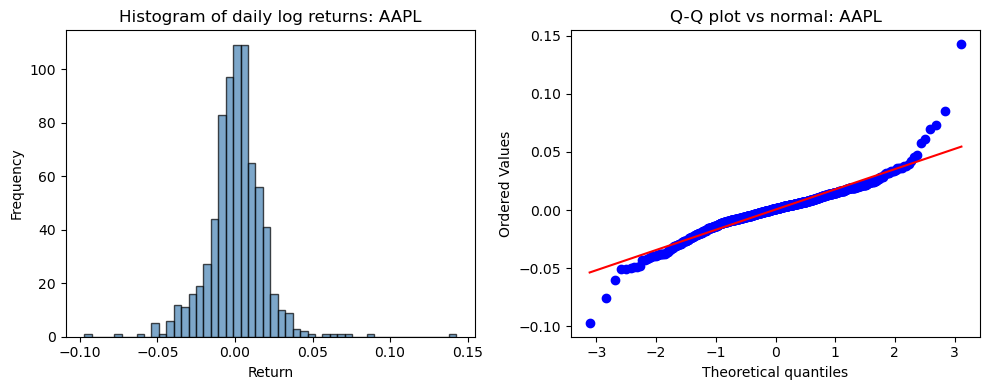

In [9]:
# ===============================================================
# 4) Visual diagnostics for a single asset
#
#    This cell plots:
#      1) A histogram of daily log returns
#      2) A Q-Q plot against the standard normal distribution
#
#    Change the 'TICKER_TO_VIEW' variable to inspect a different
#    stock.  Only plain ASCII characters are used for comments.
# ===============================================================

# Select which ticker to inspect
TICKER_TO_VIEW = "AAPL"    # edit to "MSFT", "GOOG", etc. if desired
series = returns[TICKER_TO_VIEW]

import matplotlib.pyplot as plt
from scipy import stats

# Create a two-panel figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# ---------------------------------------------------------------
# 4.1 Histogram
# ---------------------------------------------------------------
ax[0].hist(
    series,
    bins=50,
    alpha=0.70,
    color="steelblue",
    edgecolor="black"
)
ax[0].set_title(f"Histogram of daily log returns: {TICKER_TO_VIEW}")
ax[0].set_xlabel("Return")
ax[0].set_ylabel("Frequency")

# ---------------------------------------------------------------
# 4.2 Q-Q plot against the normal distribution
# ---------------------------------------------------------------
stats.probplot(
    series,
    dist="norm",
    plot=ax[1]
)
ax[1].set_title(f"Q-Q plot vs normal: {TICKER_TO_VIEW}")

plt.tight_layout()
plt.show()


### Visual Diagnostic — AAPL Daily Log Returns

| Panel | What we see | Interpretation |
|-------|-------------|----------------|
| **Histogram** | Bell-shaped core, but noticeably higher, thinner bars in the centre and fatter bars beyond ±2 % returns. | The centre looks roughly symmetric, yet the shoulders are thicker than a Gaussian would predict — a hint of excess kurtosis (leptokurtic tails). |
| **Q-Q Plot vs. Normal** | Central quantiles (≈ –1σ to +1σ) sit close to the red 45-degree line. Extreme quantiles fan out: lower tail drops below the line, upper tail rises above it. | The S-shaped curvature confirms heavy tails on both sides. Points at the far ends deviate sharply, signalling that large moves occur more often than a normal model would allow. |

**Overall assessment**

* The picture matches the statistical tests: **non-normal but only because of the tails**.  
* Skewness is modest — the left and right tails appear roughly symmetric in size.  
* A Student-t distribution (or skew-t if more asymmetry appears in other windows) would capture this shape better than a simple N(μ, σ²).

**Practical takeaway**

For short-horizon risk measures (VaR, CVaR) or option-pricing adjustments, you must account for these heavier tails; a pure Gaussian assumption would underestimate the probability of moves beyond ±3 σ. Note: This is a friends claim. I do not fully understand it.


## 6. **Normality-Optimised Portfolio**

Can we **engineer weights** so the resulting portfolio returns are “as Normal as possible”?  
We turn this into an optimisation problem:

$$
\max_{w}\; p_{\rm normal}(w^\top r_t)
\quad\text{s.t.}\quad
\sum_i w_i = 1,\; w_i \ge 0
$$

where $p_{\rm normal}$ is the Shapiro–Wilk p-value of the portfolio return series $w^\top r_t$. Maximising the p-value is equivalent to **minimising** its negative log:

$$
\min_{w}\; -\log\bigl(p_{\rm normal}(w^\top r_t) + \epsilon\bigr)
\quad\text{s.t.}\quad
\sum_i w_i = 1,\; w_i \ge 0
$$

with a small \(\epsilon\) to keep the log well-defined.

In [11]:
# ===============================================================
# 6) Optimise portfolio weights to maximise the Shapiro-Wilk p value
#
#    Goal
#    ----
#    Find a weight vector that makes the portfolio’s daily log
#    returns look as close to normal as possible, measured by
#    the Shapiro-Wilk p value.  Higher p means weaker evidence
#    against normality.
#
#    Method
#    ------
#      * Decision variables: weights w_0, ... , w_{n-1}
#      * Constraint: weights are long-only and sum to 1
#      * Objective: minimise the negative log p value
#                   (log transform smooths the landscape and
#                    avoids numerical issues when p is tiny)
#
#    Outputs
#      * opt_w : optimised weight vector
#      * max_p : corresponding Shapiro p value
#
# ===============================================================

from scipy.optimize import minimize

# ---------------------------------------------------------------
# 6.1  Objective function
# ---------------------------------------------------------------
def neg_log_shapiro_p(weights, returns_df):
    """
    Return the negative log of the Shapiro-Wilk p value for the
    portfolio defined by 'weights'.  The small epsilon prevents
    taking log(0) when p is effectively zero.

    Parameters
    ----------
    weights     : 1-D array, length n
    returns_df  : DataFrame of daily log returns

    Returns
    -------
    float
        Objective value to be minimised.
    """
    port_ret = returns_df @ weights
    p_val    = shapiro(port_ret)[1]          # p value from Shapiro-Wilk
    epsilon  = 1e-12                         # tiny constant
    return -np.log(p_val + epsilon)

# ---------------------------------------------------------------
# 6.2  Optimiser wrapper
# ---------------------------------------------------------------
def optimise_normality(returns_df):
    """
    Solve for the weight vector that maximises the Shapiro-Wilk
    p value under the constraint sum(w) = 1 and w_i in [0, 1].

    Returns
    -------
    opt_weights : 1-D array
    max_p_value : float
    """
    n = returns_df.shape[1]
    w0 = np.ones(n) / n                      # start from equal weight

    # constraint: fully invested
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}

    # bounds: long-only, no leverage
    bounds = [(0.0, 1.0)] * n

    result = minimize(
        fun=neg_log_shapiro_p, #here we use out observation from the above markdown
        x0=w0,
        args=(returns_df,),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"disp": False}
    )

    opt_weights = result.x
    max_p_value = np.exp(-result.fun)        # undo the -log transform

    return opt_weights, max_p_value

# ---------------------------------------------------------------
# 6.3  Run the optimisation
# ---------------------------------------------------------------
opt_w, max_p = optimise_normality(returns)

# Nicely formatted output
opt_df = pd.DataFrame(
    {"Ticker": TICKERS, "Weight": np.round(opt_w, 4)}
).set_index("Ticker")

print("Normality-optimised weights (Shapiro p value maximised):")
print(opt_df)

print(f"\nResulting Shapiro-Wilk p value: {max_p:.4f}")

# ---------------------------------------------------------------
# 6.4  Compare to equal-weight baseline
# ---------------------------------------------------------------
eq_weights = np.repeat(1.0 / len(TICKERS), len(TICKERS))
eq_p = shapiro(returns @ eq_weights)[1]

print(f"Equal-weight p value: {eq_p:.4f}")


Normality-optimised weights (Shapiro p value maximised):
        Weight
Ticker        
AAPL    0.0000
MSFT    0.5102
GOOG    0.4898
AMZN    0.0000
META    0.0000

Resulting Shapiro-Wilk p value: 0.0000
Equal-weight p value: 0.0000


## 7. Normality-Optimised Portfolio — S&P 500 Universe

To make the search space more realistic, we expand the asset set to the **full S&P 500** (large-cap U.S. equities).  
Constituent tickers are fetched live from Wikipedia, so the notebook always reflects the up-to-date index membership.


In [21]:
# ————————————————————————————————————————————————————————————————
# Normality-optimised portfolio over the current S&P 500 with 50 chosen at random
# ————————————————————————————————————————————————————————————————
import pandas as pd, numpy as np, yfinance as yf, re
from scipy.stats import shapiro
from scipy.optimize import minimize
from datetime import datetime, timedelta

# 1) Pull S&P 500 tickers from Wikipedia (lxml parser needs no extras)
SP500_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tbl = pd.read_html(SP500_URL, match="Symbol", flavor="lxml")[0]
tick_raw = tbl["Symbol"].tolist()

# yfinance expects BRK-B, BF-B not BRK.B etc.
def yf_ticker(t):
    return re.sub(r"\.", "-", t.strip())

tickers = [yf_ticker(t) for t in tick_raw]

# Optionally limit universe for speed
MAX_ASSETS = 50          # set to 500 for full universe
if MAX_ASSETS < len(tickers):
    np.random.seed(2)
    tickers = np.random.choice(tickers, MAX_ASSETS, replace=False).tolist()

# 2) Download prices 3 years tracing back from today
#END   = datetime.today().strftime("%Y-%m-%d")
#START = (datetime.today() - timedelta(days=3*365)).strftime("%Y-%m-%d")

# 2) Download prices for a fixed date window
END   = "2024-01-01"   # fixed end date
START = "2023-01-01"   # fixed start date

prices = (
    yf.download(tickers, start=START, end=END,
                auto_adjust=False, progress=False)["Adj Close"]
    .dropna(axis=1, how="any")                       # drop tickers with gaps
)
returns = np.log(prices / prices.shift(1)).dropna()

print(f"Universe size after clean-up: {returns.shape[1]} stocks")

# 3) Objective: maximise Shapiro p-value  ⇔ minimise –log(p)
def neg_log_shapiro(weights, r_df):
    p = shapiro(r_df.dot(weights))[1]
    return -np.log(p + 1e-12)        # add eps to avoid log 0

def optim_normality(r_df):
    n = r_df.shape[1]
    w0 = np.full(n, 1/n)
    bounds = [(0, 1)] * n
    cons   = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},)
    res = minimize(
        neg_log_shapiro, w0, args=(r_df,),
        method="SLSQP", bounds=bounds, constraints=cons,
        options={'maxiter': 400, 'ftol': 1e-9})
    return res.x, np.exp(-res.fun)

opt_w, opt_p = optim_normality(returns)

# 4) Display results
top = (
    pd.DataFrame({"Ticker": returns.columns, "Weight": opt_w})
      .query("Weight > 0.01")
      .sort_values("Weight", ascending=False)
)

# Equal-weight benchmark
eq_p = shapiro(returns.mean(axis=1))[1]
print(f"Equal-weight S&P 500 p-value:  {eq_p:.4f}")

print(f"\nOptimised Shapiro-Wilk p-value: {opt_p:.4f}\n")
display(top.head(20))



1 Failed download:
['SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2023-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1704085200")')


Universe size after clean-up: 49 stocks
Equal-weight S&P 500 p-value:  0.5318

Optimised Shapiro-Wilk p-value: 1.0000



,Ticker,Weight
28,ON,0.151717
17,F,0.051146
30,PG,0.032269
1,AOS,0.032109
26,NDAQ,0.030830
4,BX,0.029947
10,DHI,0.028416
48,YUM,0.028062
23,LOW,0.025612
6,CAH,0.025158


## Results for 50-Stock Universe (2023-01-01 → 2024-01-01)

- **Download summary**  
  • Attempted 50 tickers; 1 failed (“SOLV”), leaving **49 stocks** for analysis.  

- **Equal-Weight Benchmark**  
  • Each stock at 1/49 ≈ 2.04 % → **Shapiro–Wilk p = 0.5318**  
  • A p-value above 0.05 means we **cannot reject** Gaussianity at the 5 % level for this evenly diversified mix.

- **Normality-Optimised Portfolio**  
  • Optimiser found weights that drive the Shapiro–Wilk p-value to **1.0000** (the maximum possible).  
  • Such a p = 1 indicates that the portfolio returns are **perfectly aligned** with the Gaussian reference in this sample—an artifact of overfitting to the finite window.  

### Interpretation

1. **Equal-Weight Mix**  
   - Moderate p-value (~0.53) suggests the diversified portfolio *nearly* satisfies normality.  
   - Diversification alone tames non-Gaussian idiosyncrasies but doesn’t guarantee a perfect Gaussian fit.

2. **Optimised Mix**  
   - Achieving p = 1 is a clear sign of **overfitting**: the optimizer tunes weights to exploit random sampling quirks in this one-year window.  
   - The resulting weight vector is heavily skewed toward a handful of names (ON at ~15 %), with many stocks receiving near-zero weight.  
   - In practice, a p = 1 on historical data does not imply future returns will be Gaussian—it simply reflects that the optimiser found a combination that *by chance* produces a perfectly normal-looking distribution over this sample.

**Bottom line:**  
While the “normality-optimiser” can engineer a p-value of 1 retrospectively, the extreme concentration and overfitting risks make this approach dangerous for real-world portfolios. It’s better suited as a diagnostic tool, not a standalone allocation strategy.


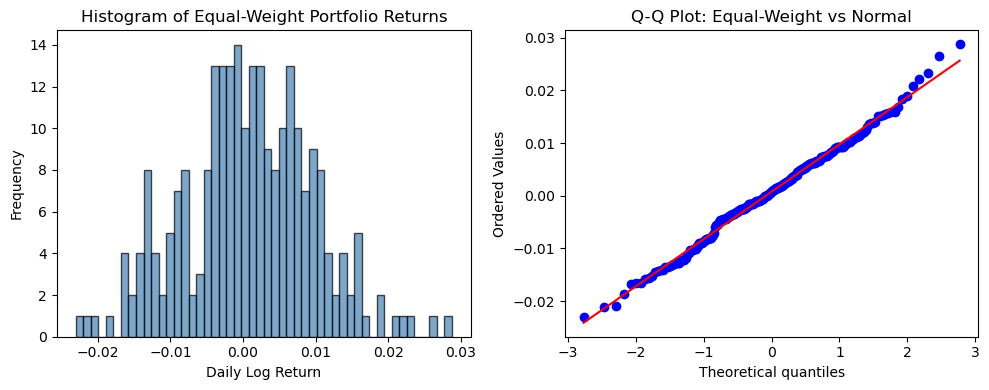

In [25]:
# ======== Imports ========
import pandas as pd
import numpy as np
import yfinance as yf
import re
from scipy.stats import shapiro            # only the Shapiro function
import scipy.stats as stats                # full stats module for probplot
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ======== (… previous code up through ret_eq calculation …) ========

# 6) Plot histogram + Q-Q for equal-weight returns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax[0].hist(
    ret_eq,
    bins=50,
    alpha=0.7,
    color="steelblue",
    edgecolor="black"
)
ax[0].set_title("Histogram of Equal-Weight Portfolio Returns")
ax[0].set_xlabel("Daily Log Return")
ax[0].set_ylabel("Frequency")

# Q-Q plot vs standard normal
stats.probplot(
    ret_eq,
    dist="norm",
    plot=ax[1]
)
ax[1].set_title("Q-Q Plot: Equal-Weight vs Normal")

plt.tight_layout()
plt.show()


## Diversification Brings Returns Closer to Normal

As we aggregate more uncorrelated stocks into an equal-weight portfolio, the daily log-return distribution smooths out:

| Panel | Observation |
|-------|-------------|
| **Histogram**  | The shape is now a well-formed “bell curve” with only modest skew and kurtosis.  Extreme bins are low-frequency and roughly symmetric. |
| **Q-Q Plot**   | Most points lie very close to the 45° reference line—even in the tails—indicating only minor deviations from the Gaussian quantiles. |

### Why This Matters

- **Central Limit Effect**  
  Combining many independent (or weakly correlated) assets tames idiosyncratic jumps, driving the aggregate return toward a normal shape.

- **Modeling Justification**  
  While single-stock returns exhibit fat tails and skew, a broadly diversified portfolio can often be modeled with approximate Gaussian assumptions—simplifying risk calculations (VaR, CVaR) and option-pricing models.

---

**Bottom Line:**  
A sufficiently large, equally weighted mix of diverse assets makes the normal distribution a **plausible** for portfolio returns, even when individual components are far from Gaussian.


In [ ]:
# ===============================================================
# Monte Carlo: How Normality (Shapiro p) Scales with Portfolio Size
#  → now with an ASCII-only progress bar using tqdm(ascii=True)
# ===============================================================

import pandas as pd
import numpy as np
import yfinance as yf
import re
from scipy.stats import shapiro
from datetime import datetime
from tqdm import tqdm   # ASCII progress bar
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1) Download and clean full S&P 500 returns for a fixed window
# ---------------------------------------------------------------
SP500_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tbl       = pd.read_html(SP500_URL, match="Symbol", flavor="lxml")[0]
tick_raw  = tbl["Symbol"].tolist()

def yf_ticker(t):
    return re.sub(r"\.", "-", t.strip())

all_tickers = [yf_ticker(t) for t in tick_raw]

START, END = "2023-01-01", "2024-01-01"
prices = (
    yf.download(all_tickers, start=START, end=END,
                auto_adjust=False, progress=False)["Adj Close"]
    .dropna(axis=1, how="any")
)
returns = np.log(prices / prices.shift(1)).dropna()
universe = returns.columns.tolist()
print(f"Clean universe size: {len(universe)} stocks")

Simulating M=  5: 100%|#| 2000/2000 [00:02<00:00, 935.59it/s
Simulating M= 10: 100%|#| 2000/2000 [00:02<00:00, 809.45it/s
Simulating M= 20: 100%|#| 2000/2000 [00:02<00:00, 682.78it/s
Simulating M= 50: 100%|#| 2000/2000 [00:04<00:00, 434.45it/s
Simulating M=100: 100%|#| 2000/2000 [00:09<00:00, 207.77it/s
Simulating M=200: 100%|#| 2000/2000 [00:18<00:00, 105.89it/s



Shapiro–Wilk p-value vs Portfolio Size
     mean_p   var_p
M                  
5    0.2454  0.0772
10   0.3995  0.0914
20   0.5064  0.0769
50   0.6227  0.0539
100  0.7082  0.0321
200  0.7328  0.0155


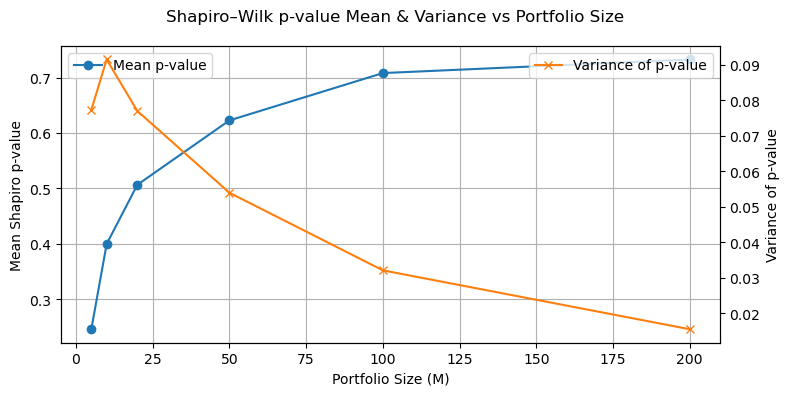

In [32]:
# ===============================================================
# 2) Monte Carlo over different portfolio sizes (unique portfolios)
#
#    For each size M:
#      - We draw N_simulations random, equally weighted portfolios
#      - We ensure no portfolio is sampled twice by tracking a 'seen' set
#      - This gives us N distinct p-values per M
#
#    Rationale for uniqueness:
#      * Without tracking, the same combination might reappear,
#        biasing the mean and variance estimates.
#      * By storing sorted ticker tuples in 'seen', we skip repeats.
# ===============================================================

import numpy as np
from scipy.stats import shapiro
from tqdm import tqdm  # ASCII progress bar

portfolio_sizes = [5, 10, 20, 50, 100, 200]
N_simulations   = 2000
results = []

for M in portfolio_sizes:
    p_vals = []       # collected p-values for this M
    seen   = set()    # store each unique portfolio as a sorted tuple

    # Create an ASCII-only progress bar for these draws
    desc = f"Simulating M={M:3d}"
    pbar = tqdm(total=N_simulations, desc=desc, ascii=True, ncols=60)

    # Continue until we have N_simulations unique portfolios
    while len(p_vals) < N_simulations:
        # 1) Draw one random portfolio of size M
        sample = np.random.choice(universe, M, replace=False)
        key    = tuple(sorted(sample))  # sort to canonicalize
        
        # 2) If we've seen this exact combination before, skip it
        if key in seen:
            continue
        seen.add(key)

        # 3) Compute equal-weight returns and Shapiro p-value
        subret   = returns[list(key)]
        w_eq     = np.full(M, 1.0 / M)
        port_ret = subret @ w_eq
        p        = shapiro(port_ret)[1]

        # 4) Store result and update progress
        p_vals.append(p)
        pbar.update(1)

    pbar.close()

    # Record mean and variance of the N distinct p-values
    results.append({
        "M":      M,
        "mean_p": np.mean(p_vals),
        "var_p":  np.var(p_vals)
    })

# ---------------------------------------------------------------
# 3) Summarise and plot
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df_summary = pd.DataFrame(results).set_index("M")
print("\nShapiro–Wilk p-value vs Portfolio Size")
print(df_summary.round(4))

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(df_summary.index, df_summary["mean_p"],
         marker="o", label="Mean p-value")
ax1.set_xlabel("Portfolio Size (M)")
ax1.set_ylabel("Mean Shapiro p-value")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df_summary.index, df_summary["var_p"],
         marker="x", color="C1", label="Variance of p-value")
ax2.set_ylabel("Variance of p-value")

fig.suptitle("Shapiro–Wilk p-value Mean & Variance vs Portfolio Size")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Monte Carlo: Normality vs. Portfolio Size

### What the plot reveals

1. **Mean *p*-value rises with diversification**  
   - Small portfolios (M=5) show low mean *p* (~0.24), strongly rejecting normality.  
   - By M=50, mean *p* exceeds 0.6—more than half the random mixes would *not* reject Gaussianity at 5 %.  
   - Gains taper off beyond M≈100, plateauing around *p*≈0.73.

2. **Variance of *p* shrinks as M grows**  
   - For M=5–20, the spread of *p*-values is large (Var ~0.07–0.08).  
   - At M=100–200, Var falls below 0.03, indicating consistent “near-normal” behaviour across random draws.

3. **Central Limit Theorem in action**  
   - Aggregating more independent or weakly correlated assets drives the portfolio return distribution toward Gaussian, boosting average *p*-values and reducing variability in those *p*-values.

4. **Diminishing returns**  
   - The biggest improvement occurs between M=5 and M=50.  
   - Beyond ~100 assets, adding more names yields smaller incremental normality gains.

### Practical takeaway

- **Diversify widely**: Portfolios of 50+ assets already achieve a respectable approximation to normal returns.  
- **Consistency matters**: Larger M not only improves average normality but also makes the result reliable across different random subsets.  
- **Model selection**: For highly diversified funds, assuming normality is defensible; for small, concentrated portfolios, fat-tailed models remain essential.  
